# Gauss-Laguerre Quadratur für die Gamma-Funktion

$$
    \Gamma(z)
    = 
    \int_0^\infty t^{z-1}e^{-t}dt
$$

$$
    \int_0^\infty f(x) e^{-x} dx 
    \approx 
    \sum_{i=1}^{N} f(x_i) w_i
    \qquad\text{ wobei }
    w_i = \frac{x_i}{(n+1)^2 [L_{n+1}(x_i)]^2}
$$
und $x_i$ sind Nullstellen des Laguerre Polynoms $L_n(x)$

Der Fehler ist gegeben als

$$
    E 
    =
    \frac{(n!)^2}{(2n)!} f^{(2n)}(\xi) 
    = 
    \frac{(-2n + z)_{2n}}{(z-m)_m} \frac{(n!)^2}{(2n)!} \xi^{z + m - 2n - 1}
$$

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from cmath import exp, pi, sin, sqrt
import scipy.special

EPSILON = 1e-07


In [74]:
lanczos_p = [
    676.5203681218851,
    -1259.1392167224028,
    771.32342877765313,
    -176.61502916214059,
    12.507343278686905,
    -0.13857109526572012,
    9.9843695780195716e-6,
    1.5056327351493116e-7,
]


def drop_imag(z):
    if abs(z.imag) <= EPSILON:
        z = z.real
    return z


def lanczos_gamma(z):
    z = complex(z)
    if z.real < 0.5:
        y = pi / (sin(pi * z) * lanczos_gamma(1 - z))  # Reflection formula
    else:
        z -= 1
        x = 0.99999999999980993
        for (i, pval) in enumerate(lanczos_p):
            x += pval / (z + i + 1)
        t = z + len(lanczos_p) - 0.5
        y = sqrt(2 * pi) * t ** (z + 0.5) * exp(-t) * x
    return drop_imag(y)


In [75]:
zeros, weights = np.polynomial.laguerre.laggauss(8)
# zeros = np.array(
#     [
#         1.70279632305101000e-1,
#         9.03701776799379912e-1,
#         2.25108662986613069e0,
#         4.26670017028765879e0,
#         7.04590540239346570e0,
#         1.07585160101809952e1,
#         1.57406786412780046e1,
#         2.28631317368892641e1,
#     ]
# )

# weights = np.array(
#     [
#         3.69188589341637530e-1,
#         4.18786780814342956e-1,
#         1.75794986637171806e-1,
#         3.33434922612156515e-2,
#         2.79453623522567252e-3,
#         9.07650877335821310e-5,
#         8.48574671627253154e-7,
#         1.04800117487151038e-9,
#     ]
# )


def pochhammer(z, n):
    return np.prod(z + np.arange(n))


def find_shift(z, target):
    factor = 1.0
    steps = int(np.floor(target - np.real(z)))
    zs = z + steps
    if steps > 0:
        factor = 1 / pochhammer(z, steps)
    elif steps < 0:
        factor = pochhammer(zs, -steps)
    return zs, factor

def find_optimal_shift(z, n):
    mhat = 1.34093 * n + 0.854093
    steps = int(np.ceil(mhat - np.real(z)))-1
    return steps


def get_shifting_factor(z, steps):
    zs = z + steps
    factor = 1.0
    if steps > 0:
        factor = 1 / pochhammer(z, steps)
    elif steps < 0:
        factor = pochhammer(zs, -steps)
    return factor


def laguerre_gamma_shift(z, x, w):
    z = complex(z)
    n = len(x)

    z += 0j
    # z_shifted, correction_factor = find_shift(z, target)
    opt_shift = find_optimal_shift(z, n)
    correction_factor = get_shifting_factor(z, opt_shift)
    z_shifted = z + opt_shift

    res = np.sum(x ** (z_shifted - 1) * w)
    res *= correction_factor
    res = drop_imag(res)
    return res


def laguerre_gamma(z, x, w, target=11):
    # res = 0.0
    z = complex(z)
    n = len(x)
    # if z.real < 1e-3:
    #     res = pi / (
    #         sin(pi * z) * laguerre_gamma(1 - z, x, w, target)
    #     )  # Reflection formula
    # else:
        # z_shifted, correction_factor = find_shift(z, target)
        # res = np.sum(x ** (z_shifted - 1) * w)
        # res *= correction_factor
    
    z_shifted, correction_factor = find_shift(z, target)
    
    # opt_shift = find_optimal_shift(z, n)
    # correction_factor = get_shifting_factor(z, opt_shift)
    # z_shifted = z + opt_shift
    
    res = np.sum(x ** (z_shifted - 1) * w)
    res *= correction_factor
    res = drop_imag(res)
    return res


In [76]:
def eval_laguerre(x, target=12):
    return np.array([laguerre_gamma(xi, zeros, weights, target) for xi in x])


def eval_laguerre2(x):
    return np.array([laguerre_gamma_shift(xi, zeros, weights) for xi in x])


def eval_lanczos(x):
    return np.array([lanczos_gamma(xi) for xi in x])


def eval_mean_laguerre(x, targets):
    return np.mean([eval_laguerre(x, target) for target in targets], 0)


def calc_rel_error(x, y):
    return (y - x) / x


def evaluate(x, target=12):
    lanczos_gammas = eval_lanczos(x)
    laguerre_gammas = eval_laguerre(x, target)
    rel_error = calc_rel_error(lanczos_gammas, laguerre_gammas)
    return rel_error

def evaluate2(x):
    lanczos_gammas = eval_lanczos(x)
    laguerre_gammas = eval_laguerre2(x)
    rel_error = calc_rel_error(lanczos_gammas, laguerre_gammas)
    return rel_error


### Test with real values

Empirische Tests zeigen:
- $n=4 \Rightarrow m=6$
- $n=5 \Rightarrow m=7$ oder $m=8$
- $n=6 \Rightarrow m=9$
- $n=7 \Rightarrow m=10$
- $n=8 \Rightarrow m=11$ oder $m=12$
- $n=9 \Rightarrow m=13$
- $n=10 \Rightarrow m=14$
- $n=11 \Rightarrow m=15$ oder $m=16$
- $n=12 \Rightarrow m=17$
- $n=13 \Rightarrow m=18 \Rightarrow $ Beginnt numerisch instabil zu werden 


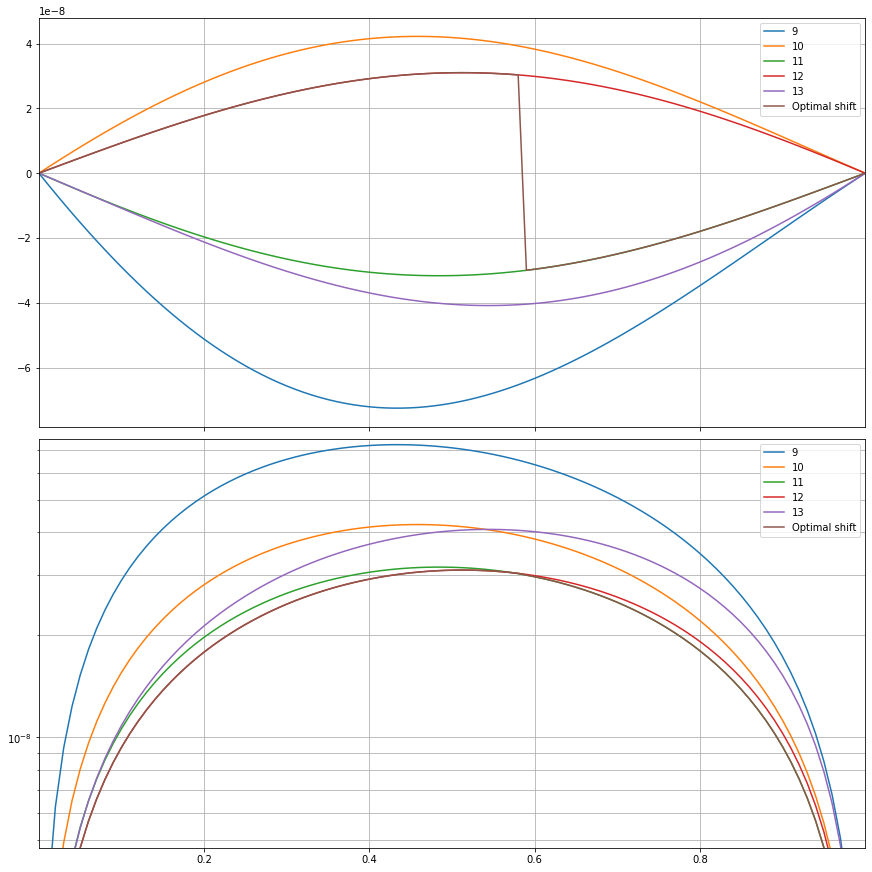

In [87]:
zeros, weights = np.polynomial.laguerre.laggauss(8)
targets = np.arange(9, 14)
mean_targets = ((9, 10),)
x = np.linspace(EPSILON, 1 - EPSILON, 101)
_, axs = plt.subplots(
    2, sharex=True, clear=True, constrained_layout=True, figsize=(12, 12)
)

lanczos = eval_lanczos(x)
# for mean_target in mean_targets:
#     vals = eval_mean_laguerre(x, mean_target)
#     rel_error_mean = calc_rel_error(lanczos, vals)
#     axs[0].plot(x, rel_error_mean, label=mean_target)
#     axs[1].semilogy(x, np.abs(rel_error_mean), label=mean_target)

mins = []
maxs = []
for target in targets:
    rel_error = evaluate(x, target)
    mins.append(np.min(np.abs(rel_error[(0.05 <= x) & (x <= 0.95)])))
    maxs.append(np.max(np.abs(rel_error)))
    axs[0].plot(x, rel_error, label=target)
    axs[1].semilogy(x, np.abs(rel_error), label=target)
    
rel_error = evaluate2(x)
axs[0].plot(x, rel_error, label="Optimal shift")
axs[1].semilogy(x, np.abs(rel_error), label="Optimal shift")

# axs[0].set_ylim(*(np.array([-1, 1]) * 3.5e-8))

axs[0].set_xlim(x[0], x[-1])
axs[1].set_ylim(np.min(mins), 1.04*np.max(maxs))
for ax in axs:
    ax.legend()
    ax.grid(which="both")


(-7.5, 25.0)

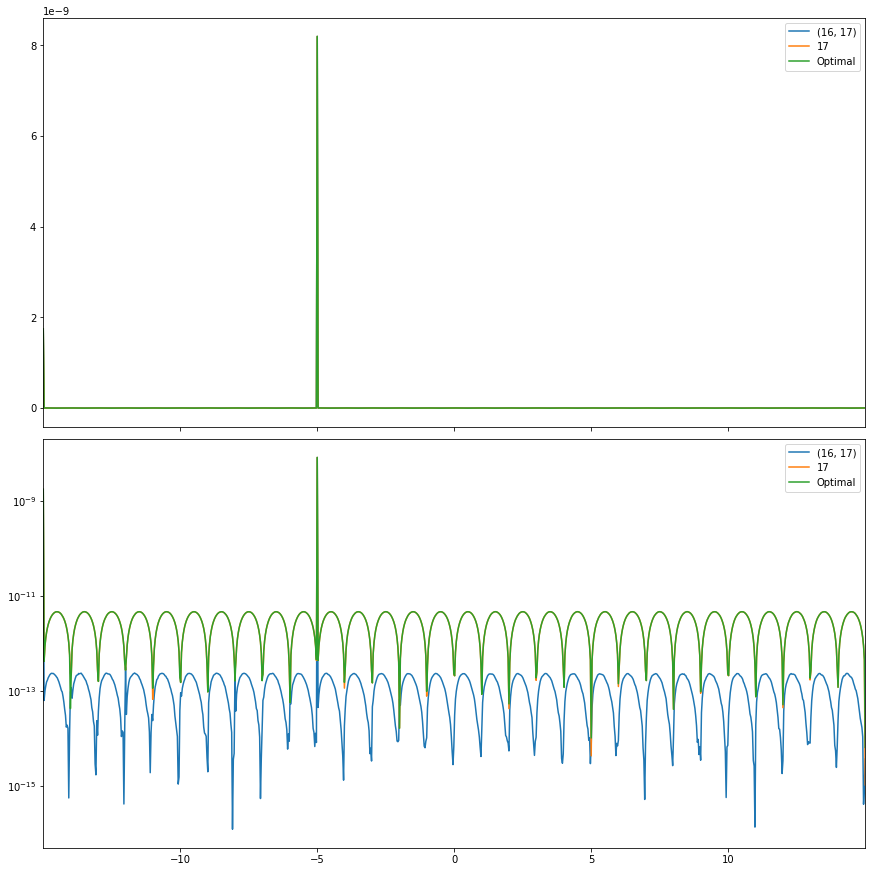

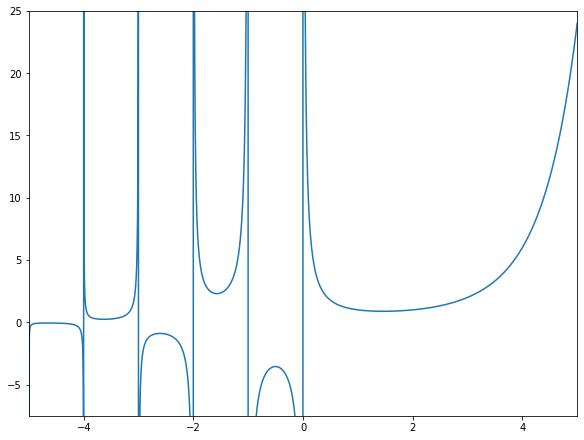

In [82]:
targets = (16, 17)
xmax = 15
x = np.linspace(-xmax + EPSILON, xmax - EPSILON, 1000)

mean_lag = eval_mean_laguerre(x, targets)
lanczos = eval_lanczos(x)
rel_error = calc_rel_error(lanczos, mean_lag)
rel_error_simple = evaluate(x, targets[-1])
rel_error_opt = evaluate2(x)
# rel_error = evaluate(x, target)

_, axs = plt.subplots(
    2, sharex=True, clear=True, constrained_layout=True, figsize=(12, 12)
)
axs[0].plot(x, rel_error, label=targets)
axs[1].semilogy(x, np.abs(rel_error), label=targets)
axs[0].plot(x, rel_error_simple, label=targets[-1])
axs[1].semilogy(x, np.abs(rel_error_simple), label=targets[-1])
axs[0].plot(x, rel_error_opt, label="Optimal")
axs[1].semilogy(x, np.abs(rel_error_opt), label="Optimal")
axs[0].set_xlim(x[0], x[-1])
# axs[0].set_ylim(*(np.array([-1, 1]) * 4.2e-8))
# axs[1].set_ylim(1e-10, 5e-8)
for ax in axs:
    ax.legend()

x2 = np.linspace(-5 + EPSILON, 5, 4001)
_, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
ax.plot(x2, eval_mean_laguerre(x2, targets))
ax.set_xlim(x2[0], x2[-1])
ax.set_ylim(-7.5, 25)


### Test with complex values

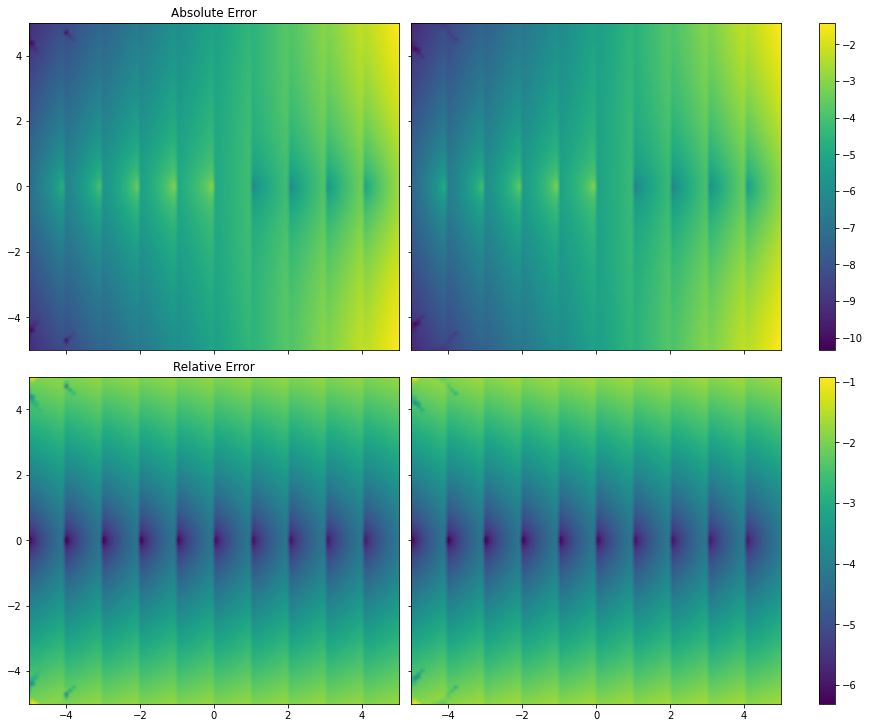

In [79]:
targets = (16, 17)
vals = np.linspace(-5 + EPSILON, 5, 100)
x, y = np.meshgrid(vals, vals)
mesh = x + 1j * y
input = mesh.flatten()

mean_lag = eval_mean_laguerre(input, targets).reshape(mesh.shape)
lanczos = eval_lanczos(input).reshape(mesh.shape)
rel_error = np.abs(calc_rel_error(lanczos, mean_lag))

lag = eval_laguerre(input, targets[-1]).reshape(mesh.shape)
rel_error_simple = np.abs(calc_rel_error(lanczos, lag))
# rel_error = evaluate(x, target)

fig, axs = plt.subplots(
    2,
    2,
    sharex=True,
    sharey=True,
    clear=True,
    constrained_layout=True,
    figsize=(12, 10),
)
_c = axs[0, 1].pcolormesh(x, y, np.log10(np.abs(lanczos - mean_lag)), shading="gouraud")
_c = axs[0, 0].pcolormesh(x, y, np.log10(np.abs(lanczos - lag)), shading="gouraud")
fig.colorbar(_c, ax=axs[0, :])
_c = axs[1, 1].pcolormesh(x, y, np.log10(rel_error), shading="gouraud")
_c = axs[1, 0].pcolormesh(x, y, np.log10(rel_error_simple), shading="gouraud")
fig.colorbar(_c, ax=axs[1, :])
_ = axs[0, 0].set_title("Absolute Error")
_ = axs[1, 0].set_title("Relative Error")


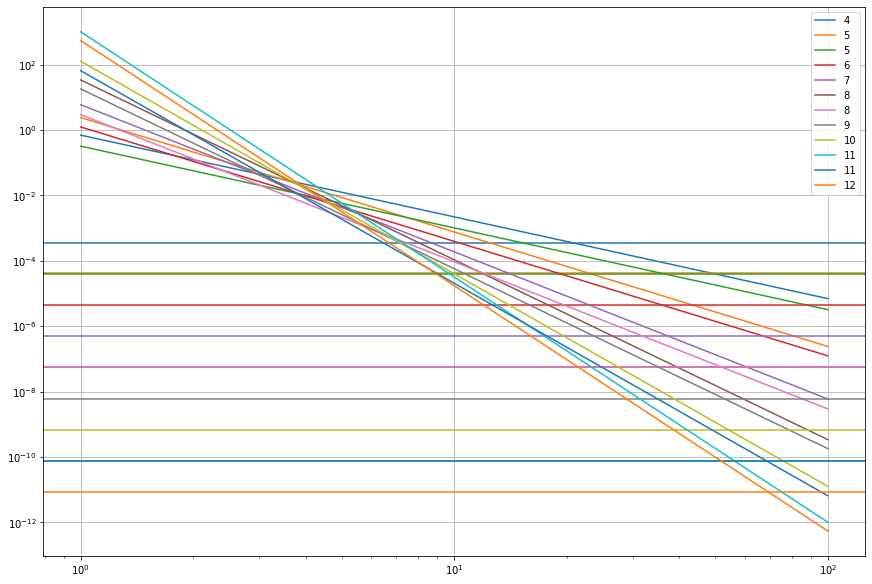

In [80]:
z = 0.5
ns = [4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 11, 12]  # np.arange(4, 13)
ms = np.arange(6, 18)
xi = np.logspace(0, 2, 201)[:, None]
lanczos = eval_lanczos([z])[0]

_, ax = plt.subplots(clear=True, constrained_layout=True, figsize=(12, 8))
ax.grid(1)
for n, m in zip(ns, ms):
    zeros, weights = np.polynomial.laguerre.laggauss(n)
    c = scipy.special.factorial(n) ** 2 / scipy.special.factorial(2 * n)
    e = np.abs(
        scipy.special.poch(z - 2 * n, 2 * n)
        / scipy.special.poch(z - m, m)
        * c
        * xi ** (z - 2 * n + m - 1)
    )
    ez = np.sum(
        scipy.special.poch(z - 2 * n, 2 * n)
        / scipy.special.poch(z - m, m)
        * c
        * zeros[:, None] ** (z - 2 * n + m - 1),
        0,
    )
    lag = eval_laguerre([z], m)[0]
    err = np.abs(lanczos - lag)
    # print(m+z,ez)
    # for zi,ezi in zip(z[0], ez):
    #     print(f"{m+zi}: {ezi}")
    # ax.semilogy(xi, e, color=color)
    lines = ax.loglog(xi, e, label=str(n))
    ax.axhline(err, color=lines[0].get_color())
    # ax.set_xticks(np.arange(xi[-1] + 1))
    # ax.set_ylim(1e-8, 1e5)
_ = ax.legend()
# _ = ax.legend([f"z={zi}" for zi in z[0]])
# _ = [ax.axvline(x) for x in zeros]


[ 3.53233831  4.88557214  6.2238806   7.56716418  8.90547264 10.23383085
 11.5721393  12.91044776 14.23880597 15.57711443 17.        ]
Intercept=1.34093, Bias=0.854093
35.0


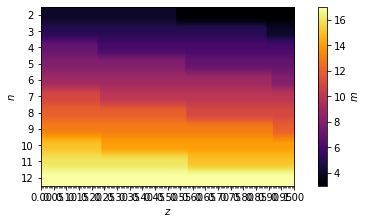

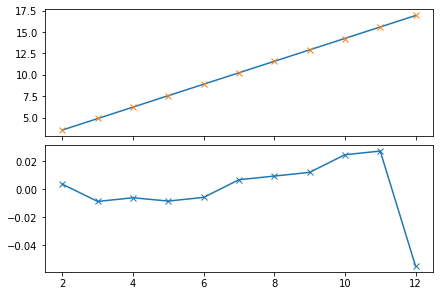

In [81]:
bests = []
N = 200
step = 1 / (N - 1)
a = 11 / 8
b = 1 / 2
x = np.linspace(step, 1 - step, N + 1)
ns = np.arange(2, 13)
for n in ns:
    zeros, weights = np.polynomial.laguerre.laggauss(n)
    est = np.ceil(b + a * n)
    targets = np.arange(max(est - 2, 0), est + 3)
    rel_errors = np.stack([np.abs(evaluate(x, target)) for target in targets], -1)
    best = np.argmin(rel_errors, -1) + targets[0]
    bests.append(best)
bests = np.stack(bests, 0)

fig, ax = plt.subplots(clear=True, constrained_layout=True, figsize=(5, 3))
v = ax.imshow(bests, cmap="inferno", aspect="auto")
plt.colorbar(v, ax=ax, label=r'$m$')
ticks = np.arange(0, N + 1, 10)
ax.set_xlim(0, 1)
ax.set_xticks(ticks, [f"{v:.2f}" for v in ticks / N])
ax.set_xticks(np.arange(N + 1), minor=True)
ax.set_yticks(np.arange(len(ns)), ns)
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$n$")
# for best in bests:
#     print(", ".join([f"{int(b):2d}" for b in best]))
# print(np.unique(bests, return_counts=True))

targets = np.mean(bests, -1)
intercept, bias = np.polyfit(ns, targets, 1)
_, axs2 = plt.subplots(2, sharex=True, clear=True, constrained_layout=True)
xl = np.array([1, ns[-1] + 1])
axs2[0].plot(ns, intercept * ns + bias)
axs2[0].plot(ns, targets, "x")
axs2[1].plot(ns, ((intercept * ns + bias) - targets), "-x")
print(np.mean(bests, -1))
print(f"Intercept={intercept:.6g}, Bias={bias:.6g}")


predicts = np.ceil(intercept * ns[:, None] + bias - x)
print(np.sum(np.abs(bests-predicts)))
# for best in predicts:
#     print(", ".join([f"{int(b):2d}" for b in best]))
